In [138]:
from bs4 import BeautifulSoup
import requests
import re
import json
from copy import deepcopy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from csv import QUOTE_NONE

## Scrape the imsdb website to extract the scripts

In [139]:
website = requests.get('https://imsdb.com/all-scripts.html')
doc = BeautifulSoup(website.text, 'html.parser')
td = doc.find_all('td', attrs={'valign':'top'})[2]
rows = td.find_all('p')


In [140]:
len(rows)

1211

In [141]:
hrefs = []
for p in rows:
    a = p.find('a')
    hrefs.append(a.attrs)

## Extract the links for all the scripts

In [142]:
scripts = []
i = 0
for link in hrefs:
    i += 1
    a_dict = {}
    try:
        script = requests.get('https://imsdb.com/'+link['href'])
        doc2 = BeautifulSoup(script.text, 'html.parser')
        href = doc2.find_all('table', attrs={'class':'script-details'})[0] \
            .find_all('td')[-1] \
            .find_all('a')[-1] \
                .attrs['href']
        a_dict['href'] = href
        a_dict['title'] = link['title'].replace(' Script','')
        scripts.append(a_dict)
        print(i)
    except Exception as e:
        print(e)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [143]:
df = pd.DataFrame(scripts)

### Extract the screenplays from the links

In [145]:
def extract_script(href):
    try:
        result = requests.get("https://imsdb.com"+href)
        doc = BeautifulSoup(result.text, "html.parser")
        pres = doc.find_all("pre")
        for pre in pres:
            text = pre.text.replace('\n','').replace('\r','').replace('\t','').replace('</b>','').replace('<b>','')
            if len(text.split()) > 10000:
                return '"""'+text+'"""'
            else:
                return 0
    except Exception:
        return 0

In [146]:
df['script'] = df['href'].apply(extract_script)

## Remove unavailable scripts

In [147]:
rows_to_drop = df.query('script == 0').index
df.drop(index=rows_to_drop,inplace=True)

In [148]:
len(df)

1174

Totally we have extracted 1174 scripts

## Count the number of words in each script and drop rows with no scripts

In [149]:
def count(text):
    try:
        count = len(text.split())
        return count
    except:
        return 0

In [150]:
df['word_count'] = df['script'].apply(count)


### scripts that were unable to scrape

In [151]:
df[df['word_count'] == 0]

,href,title,script,word_count
12,/scripts/25th-Hour.html,25th Hour,None,0
20,/scripts/8-Mile.pdf,8 Mile,None,0
29,/genre/Drama,A.I.,None,0
84,/scripts/.,Angels & Demons,None,0
122,/scripts/Back-to-the-Future.pdf,Back to the Future,None,0
...,...,...,...,...
1136,/genre/Western,Unforgiven,None,0
1142,/genre/Romance,Valentine's Day,None,0
1146,/scripts/Vertigo.pdf,Vertigo,None,0
1148,"/scripts/Village,-The.html","Village, The",None,0


<Axes: xlabel='word_count', ylabel='Count'>

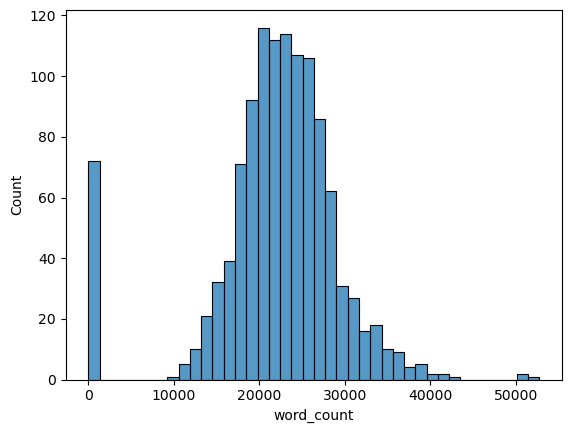

In [152]:
sns.histplot(data=df,x='word_count')

## Only keep scripts that have word count between 10,000 and 40,000

In [153]:
df = df[df['word_count'] > 10000]
df = df[df['word_count'] < 40000]

<Axes: xlabel='word_count', ylabel='Count'>

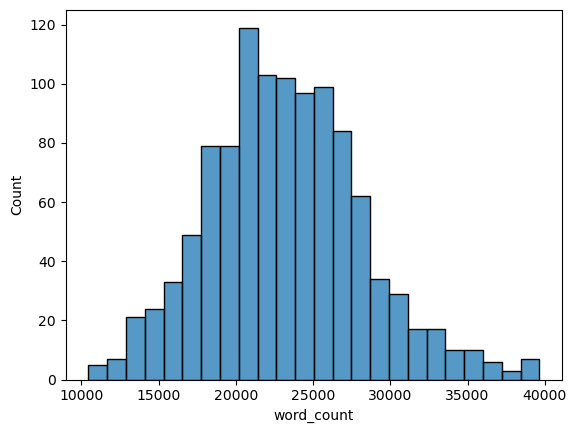

In [154]:
sns.histplot(data=df,x='word_count')

# Divide the screenplay into 100 segments

In [155]:
def split_script(script):
    scenes = []
    words = script.split()
    length = len(words)
    segment_length = length//100
    for i in range(0,100):
        segment = words[segment_length*i:segment_length*(i+1)]
        scene = ' '.join(segment)
        scenes.append(scene)
    return scenes


In [156]:
df['scenes'] = df['script'].apply(split_script)

In [157]:
df.head()

,href,title,script,word_count,scenes
0,/scripts/10-Things-I-Hate-About-You.html,10 Things I Hate About You,"""""""Ten Things I Hate About You - by Karen McCu...",18603,"[""""""Ten Things I Hate About You - by Karen McC..."
1,/scripts/12.html,12,""""""" 12 - ScriptCUT FROM BLACKTITLE: FINEXTE...",12206,"["""""" 12 - ScriptCUT FROM BLACKTITLE: FINEXTERI..."
2,/scripts/12-and-Holding.html,12 and Holding,""""""" ...",18364,"["""""" 12 AND HOLDING Written by Anthony S Cipri..."
3,/scripts/12-Monkeys.html,12 Monkeys,"""""""Twelve MonkeysTWELVE MONKEYS A...",25860,"[""""""Twelve MonkeysTWELVE MONKEYS An original s..."
4,/scripts/12-Years-a-Slave.html,12 Years a Slave,""""""" 12 YEARS A SLA...",30387,"["""""" 12 YEARS A SLAVE Written by John Ridley C..."


# Export the data into a json file

In [ ]:
df.to_json('screenplay datasets/scripts.json')

In [158]:
df.to_csv('screenplay datasets/scripts.csv',sep='\t',index=False)